## Load required modules.

TODO: Select according to shape. For example, exclude intrusions.

In [1]:
%matplotlib widget
# Import ncessary modules.
from sklearn.decomposition import PCA
import xlrd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


## Read EXCEL data file into data frame.

In [2]:
# File path to your Excel file.
file_path = 'Geochemistry Results-AGG reduced variables.xlsx'

# Define the sheet name to read.
sheet_name = 'Litogeochemistry - clean'

# Read only two columns "Th_ppm" and "U_ppm".
df = pd.read_excel(file_path, sheet_name=sheet_name)

In [3]:
df.head()

,Sample Description,Year,Depth(meters),Lithology,Shape,Comment,PTS,Al2O3_pct,BaO_pct,CaO_pct,...,Cd_ppm,Co_ppm,Cu_ppm,Li_ppm,Mo_ppm,Ni_ppm,Pb_ppm,Zn_ppm,C_pct,S_pct
0,S10-01,2022,4.44,Di-Tr dolomitic marble,Marble Units,NaN,No,0.73,0.02,26.7,...,0.25,4.0,10,20,1.0,6.0,4,27,7.22,0.23
1,S10-02,2022,14.49,Dolomitic marble,Marble Units,NaN,No,0.68,0.08,30.3,...,0.25,2.0,9,20,1.0,5.0,6,22,9.99,0.75
2,S10-03,2022,15.74,Dolomitic marble,Marble Units,NaN,No,0.56,0.01,29.4,...,0.25,1.0,5,10,1.0,4.0,3,23,10.55,0.58
3,S10-04,2022,26.80,Calcitic marble,Marble Units,NaN,Yes,0.92,0.04,37.0,...,0.25,0.5,4,20,1.0,3.0,10,31,7.76,0.26
4,S10-05,2022,27.02,Calcitic marble,Marble Units,NaN,Yes,3.18,0.08,35.4,...,0.25,3.0,9,10,1.0,7.0,4,13,7.79,1.22


In [4]:
df.shape

(103, 66)

## Remove symbols "<" and "NaN".

In [5]:
df = df.iloc[: , 7:]
df=df.replace('\<','',regex=True).astype(float)
df = df[np.isfinite(df).all(1)]
df = df.dropna()
df.head()

,Al2O3_pct,BaO_pct,CaO_pct,Fe2O3_pct,K2O_pct,MgO_pct,MnO_pct,Na2O_pct,P2O5_pct,SiO2_pct,...,Cd_ppm,Co_ppm,Cu_ppm,Li_ppm,Mo_ppm,Ni_ppm,Pb_ppm,Zn_ppm,C_pct,S_pct
0,0.73,0.02,26.7,0.72,0.20,18.70,0.06,0.48,0.13,25.27,...,0.25,4.0,10.0,20.0,1.0,6.0,4.0,27.0,7.22,0.23
1,0.68,0.08,30.3,1.44,0.28,18.15,0.11,0.40,0.20,9.90,...,0.25,2.0,9.0,20.0,1.0,5.0,6.0,22.0,9.99,0.75
2,0.56,0.01,29.4,1.23,0.05,19.40,0.10,0.29,0.16,10.46,...,0.25,1.0,5.0,10.0,1.0,4.0,3.0,23.0,10.55,0.58
3,0.92,0.04,37.0,0.59,0.17,10.20,0.05,0.62,0.07,19.68,...,0.25,0.5,4.0,20.0,1.0,3.0,10.0,31.0,7.76,0.26
4,3.18,0.08,35.4,1.78,0.09,5.33,0.05,1.82,0.08,23.63,...,0.25,3.0,9.0,10.0,1.0,7.0,4.0,13.0,7.79,1.22


In [6]:
df.shape

(103, 59)

## Scale data and apply PCA.

In [7]:
# Scale data before applying PCA
scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(df)
Scaled_data=scaling.transform(df)
 
# Set the n_components=3
pca=PCA(n_components=3)
pca.fit(Scaled_data)
x=pca.transform(Scaled_data)
 
# Check the dimensions of data after PCA
print(x.shape)

(103, 3)


## Create a datafram for PCA componenets and scale it.

In [8]:
# Create dataframe
pca_df = pd.DataFrame(
    data=x, 
    #columns=['PC1', 'PC2', 'PC3'])
    columns=['PC'+str(i) for i in range(1, len(pca.components_)+1)])
pca_df

,PC1,PC2,PC3
0,-2.904121,-0.687502,-1.153024
1,-2.373494,0.971286,-1.018139
2,-3.351016,0.273103,-0.897033
3,-1.068464,0.890351,-1.551955
4,1.256470,0.581373,-0.742524
...,...,...,...
98,8.492903,-3.062950,2.291491
99,8.186120,-3.821682,2.597764
100,-3.457230,-0.788820,-1.570951
101,-4.381459,0.132171,-1.652483


In [9]:
# Create the scaled PCA dataframe
pca_df_scaled = pca_df.copy()
  
scaler_df = pca_df[['PC1', 'PC2', 'PC3']]
scaler = 1 / (scaler_df.max() - scaler_df.min())
  
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]

## Display loadings.

In [10]:
#loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=df.columns)
loadings = pd.DataFrame(pca.components_.T, columns=['PC'+str(i) for i in range(1, len(pca.components_)+1)], index=df.columns)
loadings

,PC1,PC2,PC3
Al2O3_pct,0.180261,-0.185359,0.016116
BaO_pct,0.024680,0.125858,-0.065522
CaO_pct,-0.142331,0.198317,-0.091482
Fe2O3_pct,0.115688,-0.036155,0.260673
K2O_pct,0.098494,-0.043678,-0.059100
MgO_pct,-0.136432,0.071195,-0.020192
MnO_pct,-0.094592,0.170333,0.184271
Na2O_pct,0.169173,-0.186011,0.056581
P2O5_pct,0.097717,0.237639,-0.014531
SiO2_pct,0.138027,-0.225922,-0.036639


## Display sorted loadings.

In [11]:
sorted_loadings = loadings.sort_values(by='PC1', ascending=False)  # Change 'ascending' as needed
sorted_loadings

,PC1,PC2,PC3
TiO2_pct,0.195949,-0.140755,0.025195
Tm_ppm,0.191060,0.052825,0.056302
Er_ppm,0.190792,0.093998,0.034395
Ta_ppm,0.188850,-0.140230,0.015115
Ho_ppm,0.188180,0.136500,0.008733
Nb_ppm,0.187310,-0.123425,-0.010697
Lu_ppm,0.185558,0.010767,0.077332
Yb_ppm,0.185426,0.021013,0.070684
Zr_ppm,0.183912,-0.094314,-0.036313
Y_ppm,0.183367,0.152319,0.004874


In [12]:
sorted_loadings = loadings.sort_values(by='PC2', ascending=False)  # Change 'ascending' as needed
sorted_loadings

,PC1,PC2,PC3
P2O5_pct,0.097717,0.237639,-0.014531
Sm_ppm,0.160174,0.227373,-0.082964
Nd_ppm,0.151188,0.226907,-0.095496
Eu_ppm,0.152673,0.222928,-0.081283
Gd_ppm,0.164454,0.215763,-0.061135
Pr_ppm,0.139769,0.215138,-0.095558
Ce_ppm,0.126893,0.206326,-0.089268
Tb_ppm,0.170621,0.199691,-0.044206
CaO_pct,-0.142331,0.198317,-0.091482
La_ppm,0.085348,0.184389,-0.077520


In [13]:
sorted_loadings = loadings.sort_values(by='PC3', ascending=False)  # Change 'ascending' as needed
sorted_loadings

,PC1,PC2,PC3
Se_ppm,-0.010507,0.090971,0.373598
Cd_ppm,-0.025655,0.095289,0.337421
Zn_ppm,-0.025999,0.094769,0.335291
In_ppm,-0.022009,0.091095,0.322806
S_pct,0.064049,-0.005180,0.318976
Fe2O3_pct,0.115688,-0.036155,0.260673
Hg_ppm,-0.014188,0.077241,0.226618
Ag_ppm,-0.024403,0.042006,0.185775
MnO_pct,-0.094592,0.170333,0.184271
Cu_ppm,0.052287,0.132321,0.164487


## Plot a 3D scatter plot with arrows for PCA directions.

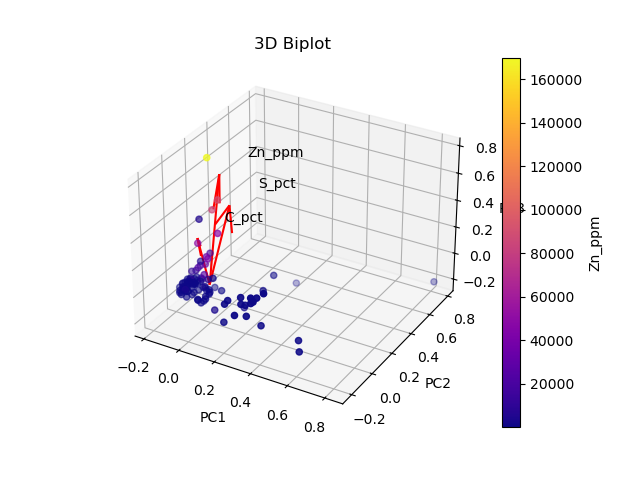

In [14]:
# Initialize the 3D graph
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
  
# Define scaled features as arrays
xdata = pca_df_scaled['PC1']
ydata = pca_df_scaled['PC2']
zdata = pca_df_scaled['PC3']

# This will be used to color the scatter plot.
color_name='Zn_ppm'
  
# Plot 3D scatterplot of PCA
p=ax.scatter3D(
    xdata, 
    ydata, 
    zdata, 
    c=df[color_name],
    cmap='plasma'
    #c=zdata, 
    #cmap='Greens', 
    #alpha=0.5
)
#fig.colorbar(p,orientation='horizontal',label=color_name)
fig.colorbar(p,label=color_name)

# Arrows will be displayed for the following.
show_names=['Zn_ppm', 'C_pct', 'S_pct']
indx=df.columns.get_indexer(show_names)
scale=2
  
# Define the x, y, z variables
loadings = pca.components_
xs = scale*loadings[0]
ys = scale*loadings[1]
zs = scale*loadings[2]

# Plot the loadings
for i , names in enumerate(show_names):
    ip=indx[i]
    #ax.scatter(xs[ip], ys[ip], zs[ip], s=100)
    ax.text(
         xs[ip] + 0.1, 
         ys[ip] + 0.1, 
         zs[ip] + 0.1, 
         names)
  
# Plot the arrows
x_arr = np.zeros(len(loadings[0]))
y_arr = z_arr = x_arr
# Plot specific arrow
#indx=df.columns.get_loc("Zn_ppm")
ax.quiver(x_arr[indx], y_arr[indx], z_arr[indx], xs[indx], ys[indx], zs[indx],color='r')
  
# Plot title of graph
plt.title(f'3D Biplot')
  
# Plot x, y, z labels
ax.set_xlabel('PC1')#, rotation=150)
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')#, rotation=60)
plt.savefig('3D_biplot.svg')

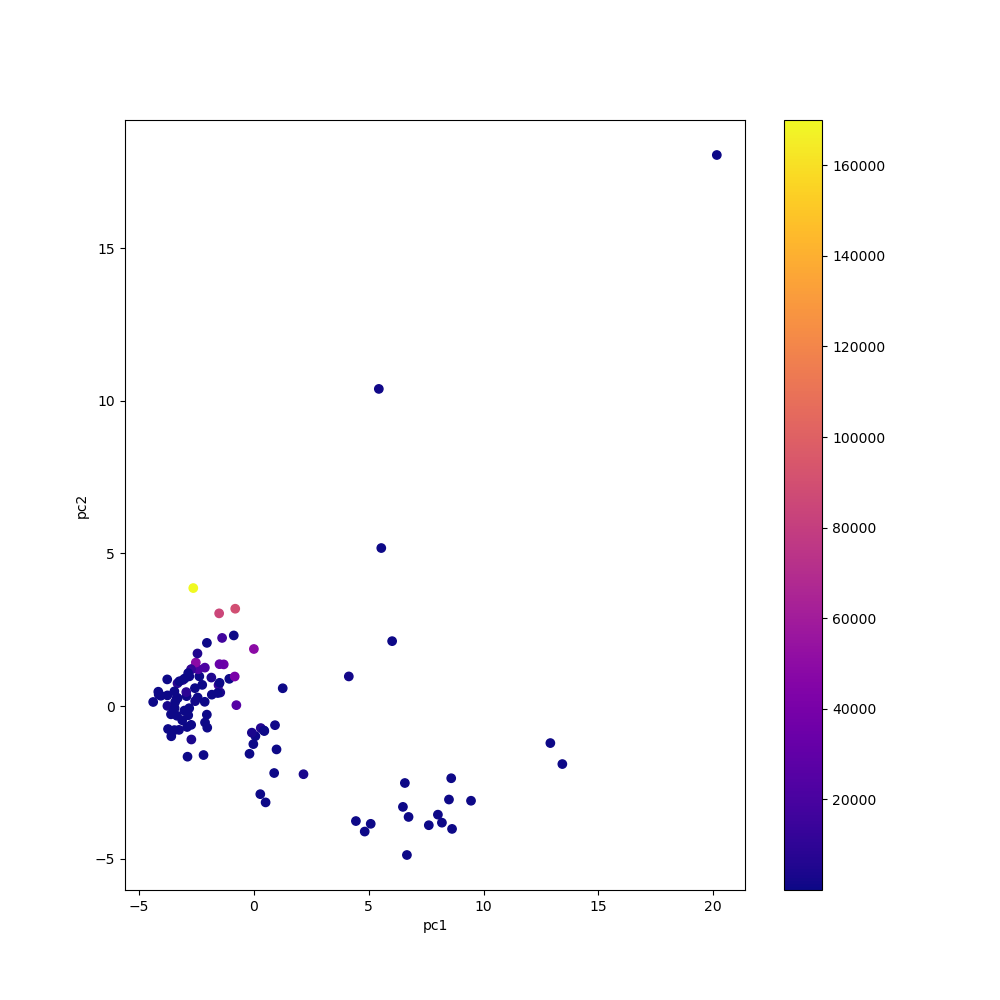

In [42]:
plt.figure(figsize=(10,10))
#plt.scatter(x[:,0],x[:,1],c=data['target'],cmap='plasma')
plt.scatter(x[:,0],x[:,1],c=df['Zn_ppm'],cmap='plasma')

## Plot the arrows
#x_arr = np.zeros(len(loadings[0]))
#y_arr = z_arr = x_arr
#plt.quiver(x_arr, y_arr, z_arr, xs, ys, zs)

plt.xlabel('pc1')
plt.ylabel('pc2')
plt.colorbar()

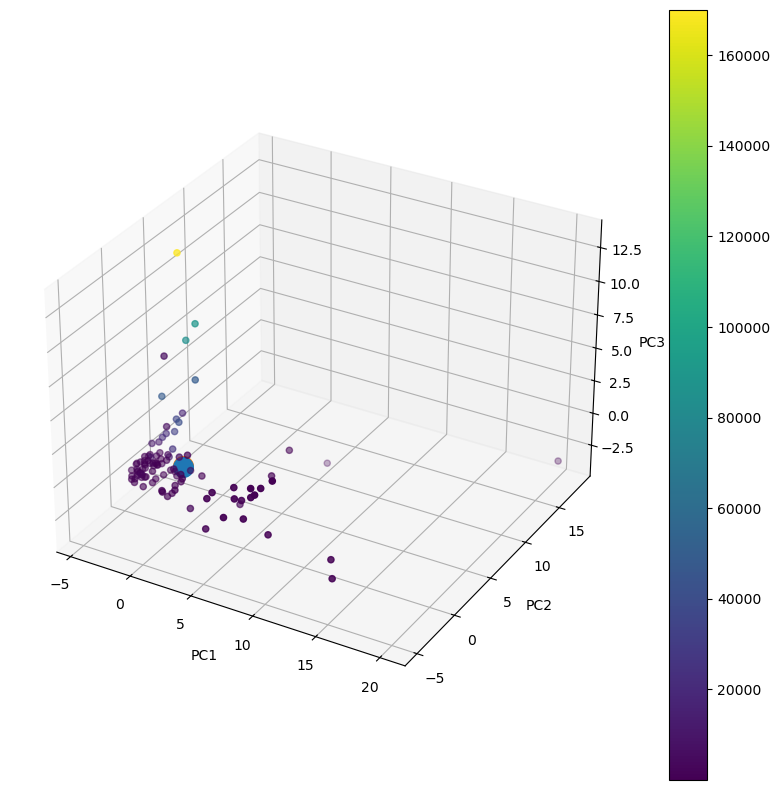

In [14]:
# import relevant libraries for 3d graph
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
img=axis.scatter(x[:,0],x[:,1],x[:,2], c=df['Zn_ppm'])

# Plot the loadings
for i in range(2):
    axis.scatter(xs[i], ys[i], zs[i], s=200)
    #axis.text(
    #    xs[i] + 0.1, 
    #    ys[i] + 0.1, 
    #    zs[i] + 0.1, 
    #    varnames)
  
# Plot the arrows
x_arr = np.zeros(len(loadings[0]))
y_arr = z_arr = x_arr
axis.quiver(x_arr, y_arr, z_arr, xs, ys, zs)

axis.set_xlabel("PC1")
axis.set_ylabel("PC2")
axis.set_zlabel("PC3")
fig.colorbar(img)

In [11]:
# Remove all rows that have at least one NaN.
df = df.dropna()

# Remove "<" from the values.
df['Th_ppm'] = df['Th_ppm'].apply(lambda x: x.replace('<', '') if isinstance(x, str) and '<' in x else x)
df['U_ppm'] = df['U_ppm'].apply(lambda x: x.replace('<', '') if isinstance(x, str) and '<' in x else x)

# Change to "object" to "float".
df['Th_ppm'] = df['Th_ppm'].astype(float)
df['U_ppm'] = df['U_ppm'].astype(float)

In [12]:
# Set the data for clustering
X = df[['Th_ppm', 'U_ppm']].values

# Choose the number of clusters (k)
k = 3

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

# Add cluster labels to the DataFrame
df['cluster'] = kmeans.labels_

/home/hngharti/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


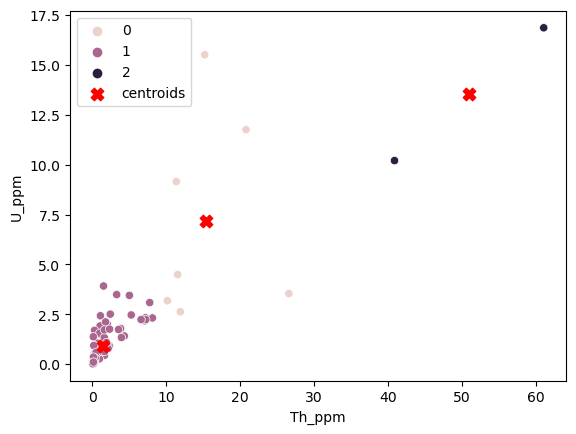

In [13]:
# Scatter plot with the centroids.
sns.scatterplot(data=df, x="Th_ppm", y="U_ppm", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="X", c="r", s=80, label="centroids")
plt.legend()
plt.show()

/home/hngharti/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hngharti/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hngharti/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hngharti/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hnghar

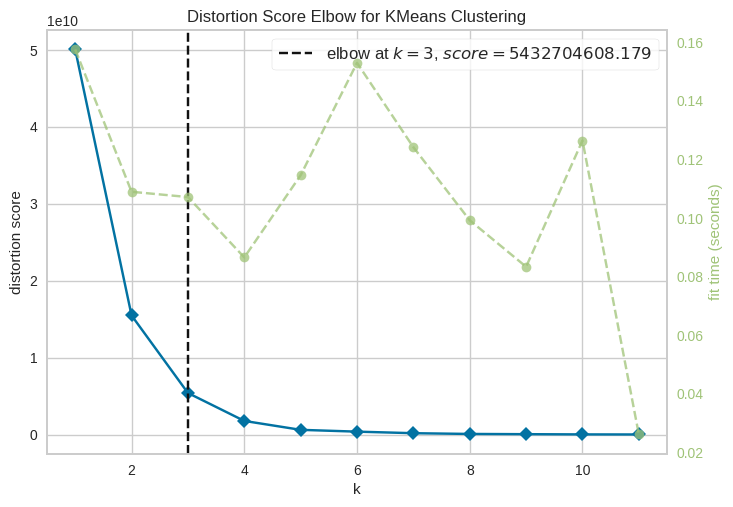

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
# Plot the distortion score elbow.
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(df)
visualizer.show()

In [15]:
#import the breast _cancer dataset
from sklearn.datasets import load_breast_cancer
data=load_breast_cancer()
data.keys()
 
# Check the output classes
print(data['target_names'])
 
# Check the input attributes
print(data['feature_names'])

['malignant' 'benign']
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [18]:
# construct a dataframe using pandas
df1=pd.DataFrame(data['data'],columns=data['feature_names'])

In [19]:
df1.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [20]:
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [35]:
a=[{'T1'},{'T2}]

SyntaxError: unterminated string literal (detected at line 1) (3611873704.py, line 1)